## Mean-variance Portfolio Optimization using QAOA and VQE


In [1]:
%pip install qiskit_aer

  Using cached qiskit_aer-0.15.1-cp311-cp311-macosx_11_0_arm64.whl.metadata (8.0 kB)
Using cached qiskit_aer-0.15.1-cp311-cp311-macosx_11_0_arm64.whl (2.2 MB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
from qiskit.circuit.library import TwoLocal
from qiskit.result import QuasiDistribution
from qiskit_aer.primitives import Sampler
from qiskit_algorithms import NumPyMinimumEigensolver, QAOA, SamplingVQE
from qiskit_algorithms.optimizers import COBYLA
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import RandomDataProvider
from qiskit_optimization.algorithms import MinimumEigenOptimizer
import numpy as np
import matplotlib.pyplot as plt
import datetime

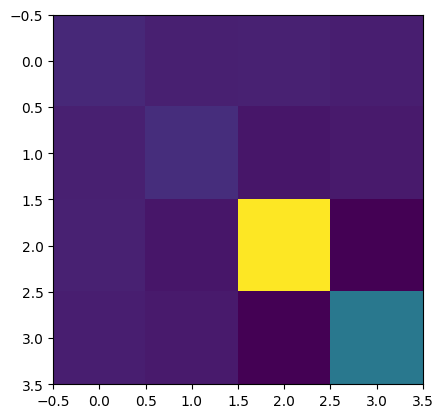

In [10]:
# Load stocks data
num_assets = 4
seed = 129
stocks = [("TICKER%s" % i) for i in range(num_assets)]
data = RandomDataProvider(tickers=stocks, start=datetime.datetime(2024, 1, 1), end=datetime.datetime(2024, 1, 30), seed=seed)
data.run()
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()
plt.imshow(sigma, interpolation="nearest")
plt.show()



In [15]:
risk_factor = 0.5
budget = num_assets //2 
penalty = num_assets
portfolio = PortfolioOptimization(expected_returns=mu, covariances=sigma, risk_factor=risk_factor, budget=budget)
quad_program = portfolio.to_quadratic_program()
print(quad_program)


## Pretty print the results
def print_result(result):
  selection = result.x
  value = result.fval
  print(f"Optimal: Selected Asset - {selection}   Risk: {value}")
  eigen_state = result.min_eigen_solver_result.eigenstate
  probabilities = (
    eigen_state.binary_probabilities()
    if isinstance(eigen_state, QuasiDistribution)
    else {k: np.abs(v)**2 for k,v in eigen_state.to_dict().items()}
  )
  print("Full results")
  print("Selected Assets\tRisk\tOccurance Probablity")
  print("--"*20)
  probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)
  for k, v in probabilities:
        x = np.array([int(i) for i in list(reversed(k))])
        value = quad_program.objective.evaluate(x)
        print("%10s\t%.4f\t\t%.4f" % (x, value, v))



minimize 0.000157580014499559*x_0^2 + 5.005764461849371e-06*x_0*x_1 + 6.459560212560816e-05*x_0*x_2 - 5.6591477695651116e-05*x_0*x_3 + 0.00024050692578291805*x_1^2 - 0.000299666776334722*x_1*x_2 - 0.0001906314523475045*x_1*x_3 + 0.005077135594181944*x_2^2 - 0.0009777651106963887*x_2*x_3 + 0.0017409379798213286*x_3^2 - 0.0024403884253402985*x_0 + 0.0028600309140853326*x_1 - 0.004735393149061621*x_2 - 0.022266701289053732*x_3 (4 variables, 1 constraints, 'Portfolio optimization')


In [16]:
# Solving the problem classically using the numpy's eigensolver
mineignesolver = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = mineignesolver.solve(quad_program)
print_result(result)

Optimal: Selected Asset - [1. 0. 0. 1.]   Risk: -0.022865163197768795
Full results
Selected Assets	Risk	Occurance Probablity
----------------------------------------
 [1 0 0 1]	-0.0229		1.0000


In [ ]:
from qiskit_algorithms.utils import algorithm_globals
algorithm_globals.random_seed = 1234
cobyla = COBYLA()
cobyla.set_options(maxiter=500)
sampling_vqe = SamplingVQE(
  sampler=Sampler(),
  optimizer=cobyla,
  ansatz=TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
  )
sampling_vqe = MinimumEigenOptimizer(sampling_vqe)
result = sampling_vqe.solve(quad_program)
print_result(result)

Optimal: Selected Asset - [1. 0. 0. 1.]   Risk: -0.022865163197768795
Full results
Selected Assets	Risk	Occurance Probablity
----------------------------------------
 [1 0 0 1]	-0.0229		0.7646
 [0 1 1 0]	0.0031		0.1514
 [1 1 1 0]	0.0009		0.0303
 [0 0 0 1]	-0.0205		0.0205
 [1 0 0 0]	-0.0023		0.0117
 [0 0 1 1]	-0.0212		0.0098
 [0 1 0 0]	0.0031		0.0039
 [1 1 1 1]	-0.0208		0.0029
 [0 0 1 0]	0.0003		0.0020
 [0 1 1 1]	-0.0186		0.0020
 [1 0 1 1]	-0.0234		0.0010


In [18]:
algorithm_globals.random_seed = 1234
cobyla = COBYLA()
cobyla.set_options(max_iter=200)
qaoa = QAOA(
  sampler=Sampler(),
  optimizer=cobyla,
  reps=3
)
qaoa = MinimumEigenOptimizer(qaoa)
result = qaoa.solve(quad_program)
print_result(result)

/Users/bhargavcn/Projects/quantum-finance/venv/lib/python3.11/site-packages/scipy/optimize/_minimize.py:744: OptimizeWarning: Unknown solver options: max_iter
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimal: Selected Asset - [1. 0. 0. 1.]   Risk: -0.022865163197768795
Full results
Selected Assets	Risk	Occurance Probablity
----------------------------------------
 [1 0 0 1]	-0.0229		0.1914
 [0 1 1 0]	0.0031		0.1816
 [0 1 0 1]	-0.0176		0.1729
 [1 1 0 0]	0.0008		0.1562
 [1 0 1 0]	-0.0019		0.1484
 [0 0 1 1]	-0.0212		0.1377
 [1 1 1 1]	-0.0208		0.0059
 [0 0 0 0]	0.0000		0.0020
 [1 1 0 1]	-0.0200		0.0010
 [1 1 1 0]	0.0009		0.0010
 [1 0 0 0]	-0.0023		0.0010
 [0 0 1 0]	0.0003		0.0010
